In [1]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import rl_utils

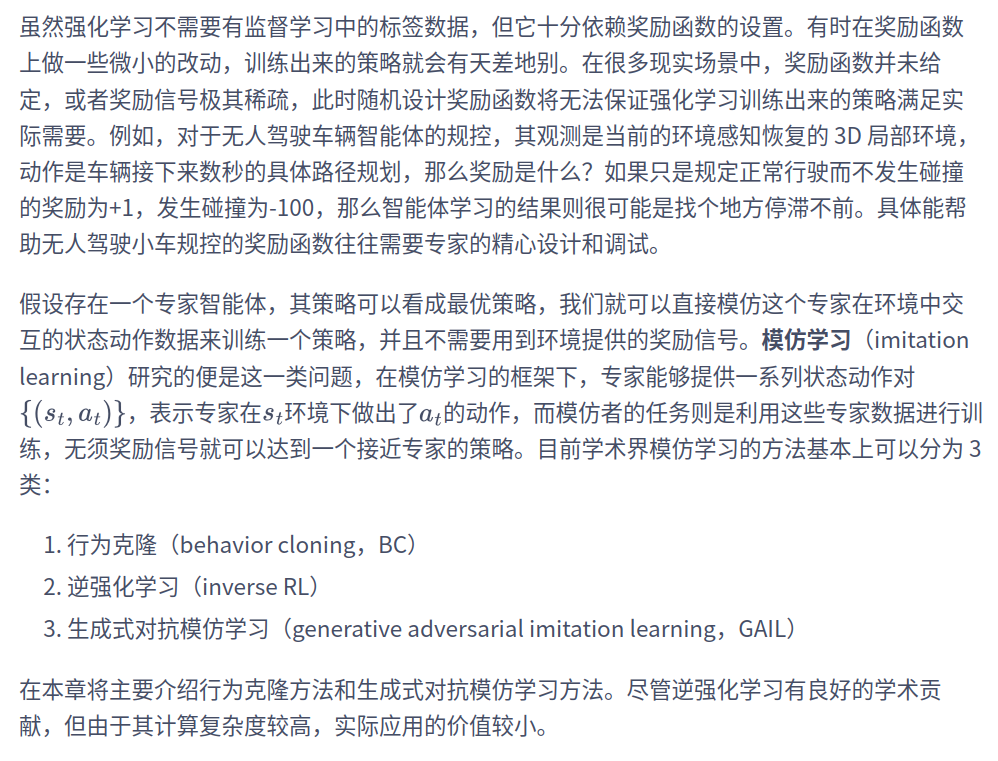
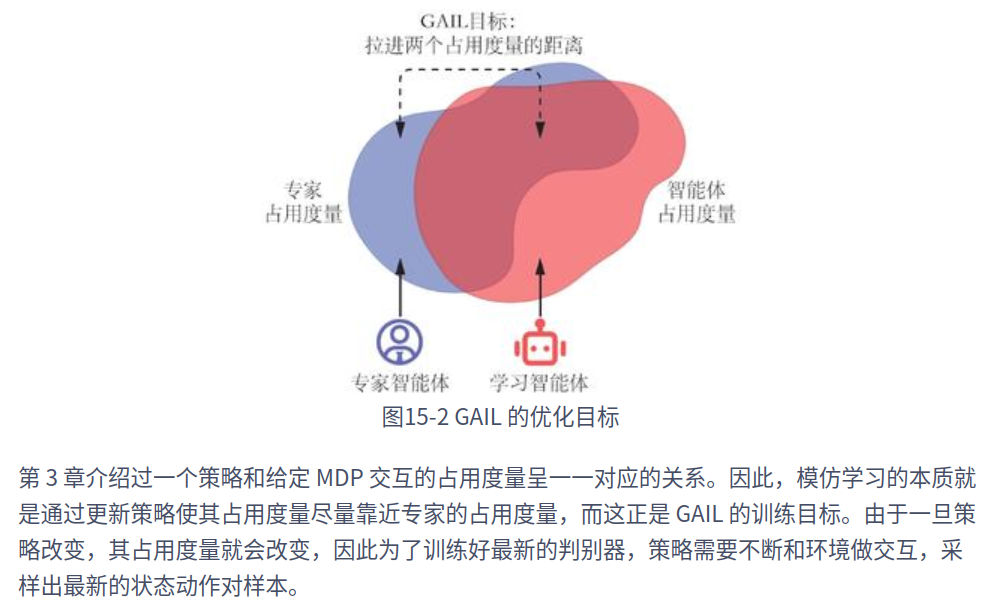
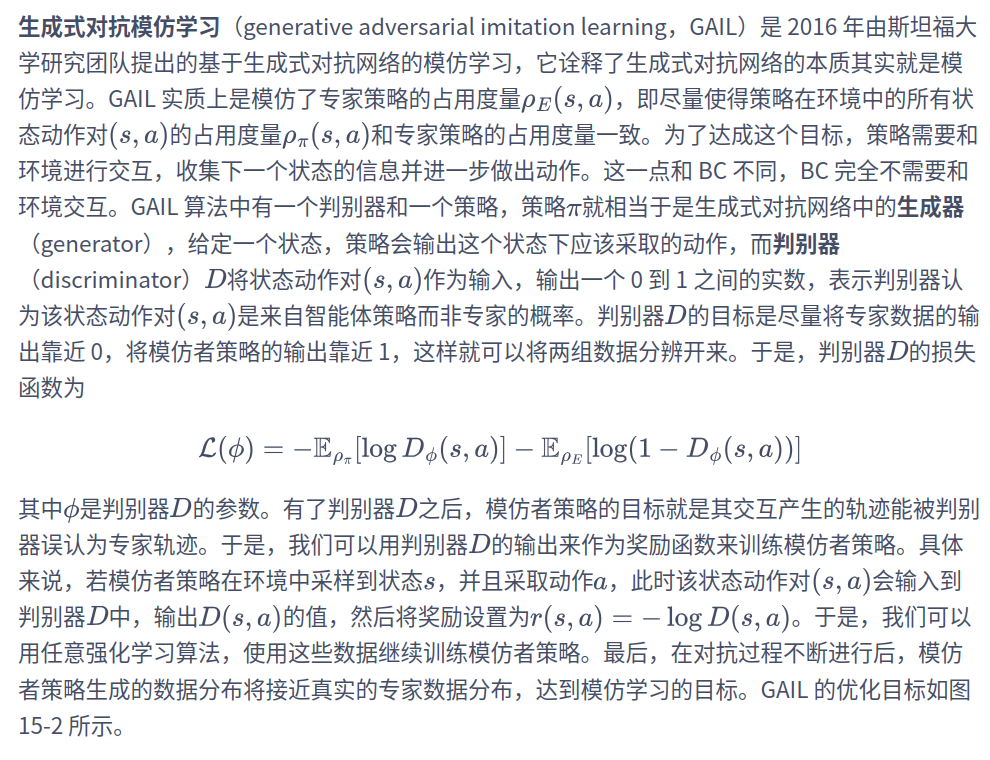

In [ ]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)
        # 输出每个动作的概率

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [3]:
class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用于训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()


In [4]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 250
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
ppo_agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
                epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, ppo_agent, num_episodes)

Iteration 0:   0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_5962/2574601832.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 25/25 [00:07<00:00,  3.40it/s, episode=245, return=500.000]


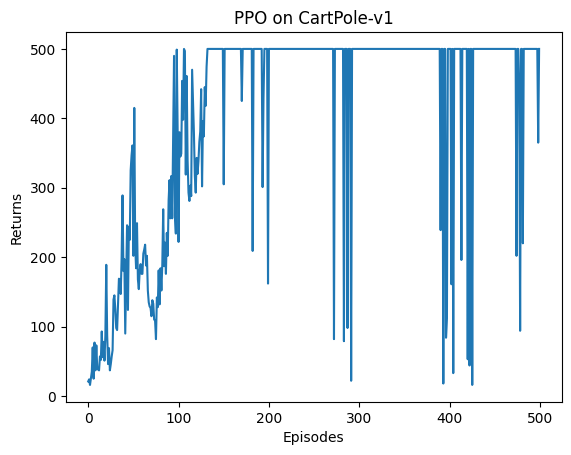

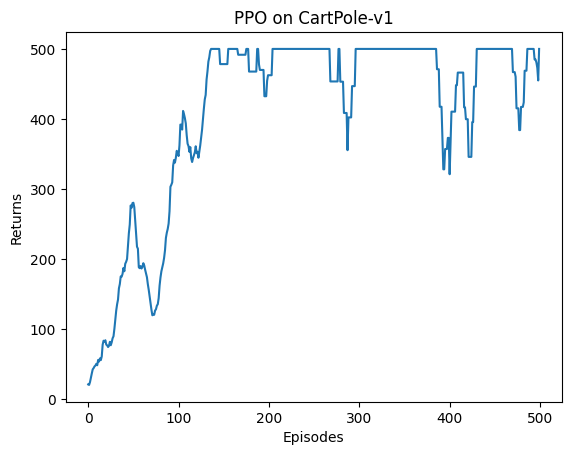

In [21]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [ ]:
def sample_expert_data(n_episode):
    states = []
    actions = []
    for episode in range(n_episode):
        state = env.reset()[0]
        done = False
        while not done:
            action = ppo_agent.take_action(state)
            states.append(state)
            actions.append(action)
            next_state, reward, done, truncated ,_= env.step(action)
            # 有些环境没有done，时间到了truncated为true
            done = done or truncated
            state = next_state
    return np.array(states), np.array(actions)

env.reset(seed=0)
torch.manual_seed(0)
random.seed(0)
n_episode = 1
expert_s, expert_a = sample_expert_data(n_episode)

n_samples = 30  # 采样30个数据
random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]

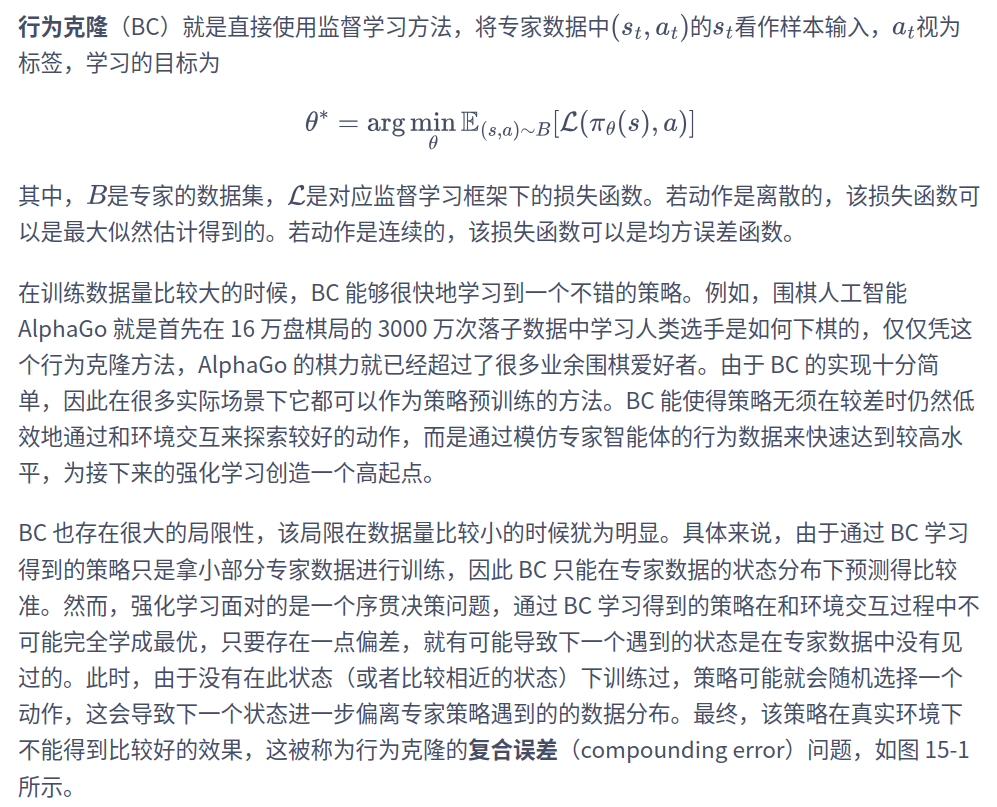  
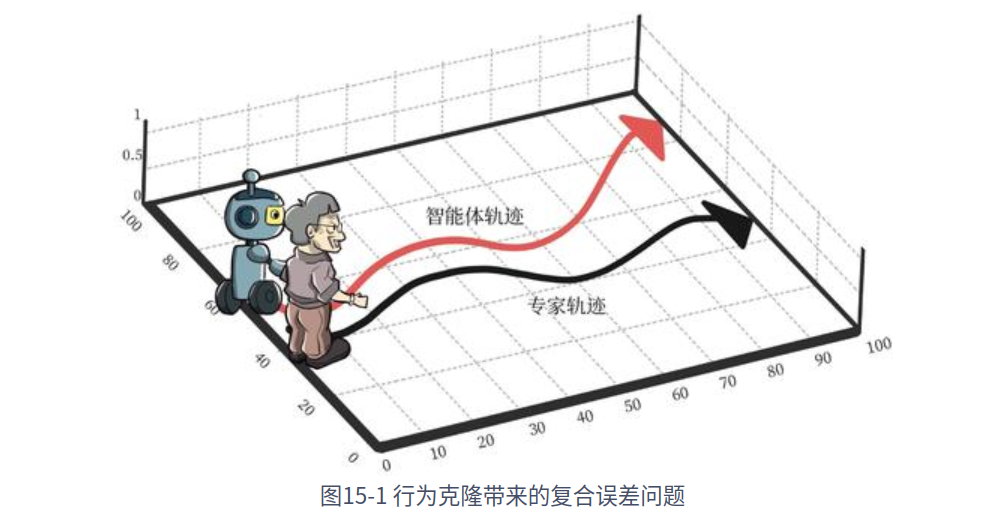

In [13]:
class BehaviorClone:
    def __init__(self, state_dim, hidden_dim, action_dim, lr):
        self.policy = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def learn(self, states, actions):
        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions).view(-1, 1).to(device)
        log_probs = torch.log(self.policy(states).gather(1, actions))
        bc_loss = torch.mean(-log_probs)  # 最大似然估计,交叉熵损失

        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(device)
        probs = self.policy(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

def test_agent(agent, env, n_episode):
    return_list = []
    for episode in range(n_episode):
        episode_return = 0
        state = env.reset()[0]
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, truncated ,_= env.step(action)
            # 有些环境没有done，时间到了truncated为true
            done = done or truncated
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
    return np.mean(return_list)

# 进度条: 100%|██████████| 1000/1000 [00:50<00:00, 19.82it/s, return=42.000]

In [14]:
env.reset(seed=0)
torch.manual_seed(0)
np.random.seed(0)

lr = 1e-3
bc_agent = BehaviorClone(state_dim, hidden_dim, action_dim, lr)
n_iterations = 1000
batch_size = 64
test_returns = []

with tqdm(total=n_iterations, desc="进度条") as pbar:
    for i in range(n_iterations):
        sample_indices = np.random.randint(low=0,high=expert_s.shape[0],
                                           size=batch_size)
        bc_agent.learn(expert_s[sample_indices], expert_a[sample_indices])
        current_return = test_agent(bc_agent, env, 5)
        test_returns.append(current_return)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(test_returns[-10:])})
        pbar.update(1)

进度条:   0%|          | 0/1000 [00:00<?, ?it/s]

进度条: 100%|██████████| 1000/1000 [07:29<00:00,  2.22it/s, return=356.720]


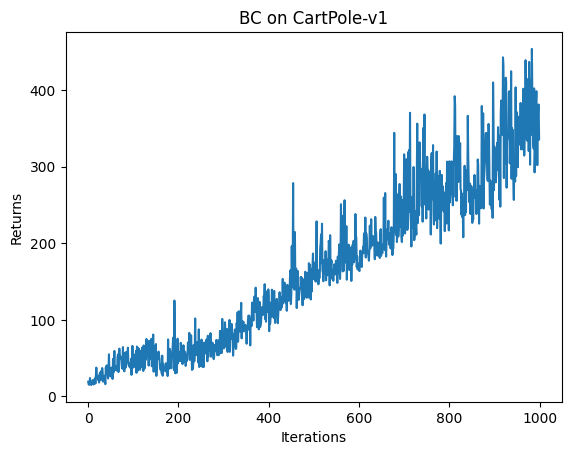

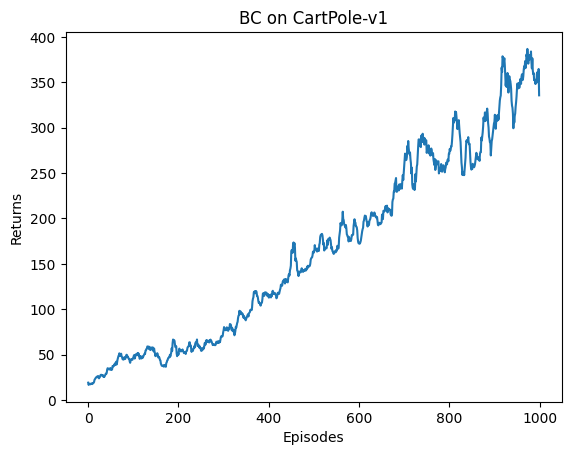

In [25]:
iteration_list = list(range(len(test_returns)))
plt.plot(iteration_list, test_returns)
plt.xlabel('Iterations')
plt.ylabel('Returns')
plt.title('BC on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(test_returns, 9)
plt.plot(iteration_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('BC on {}'.format(env_name))
plt.show()

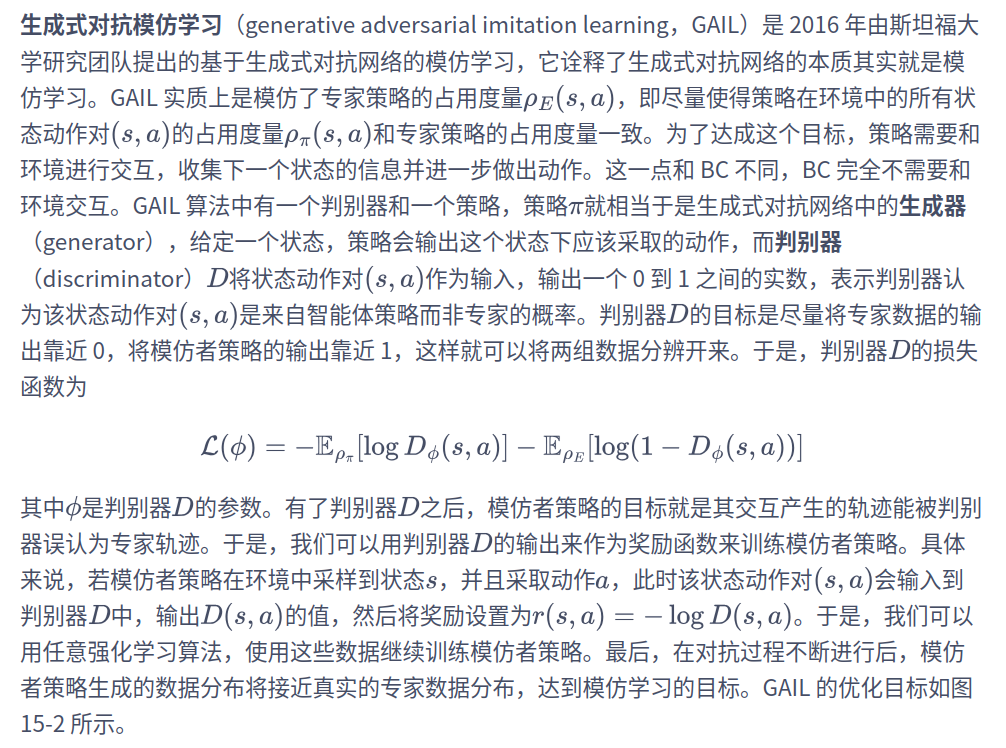  
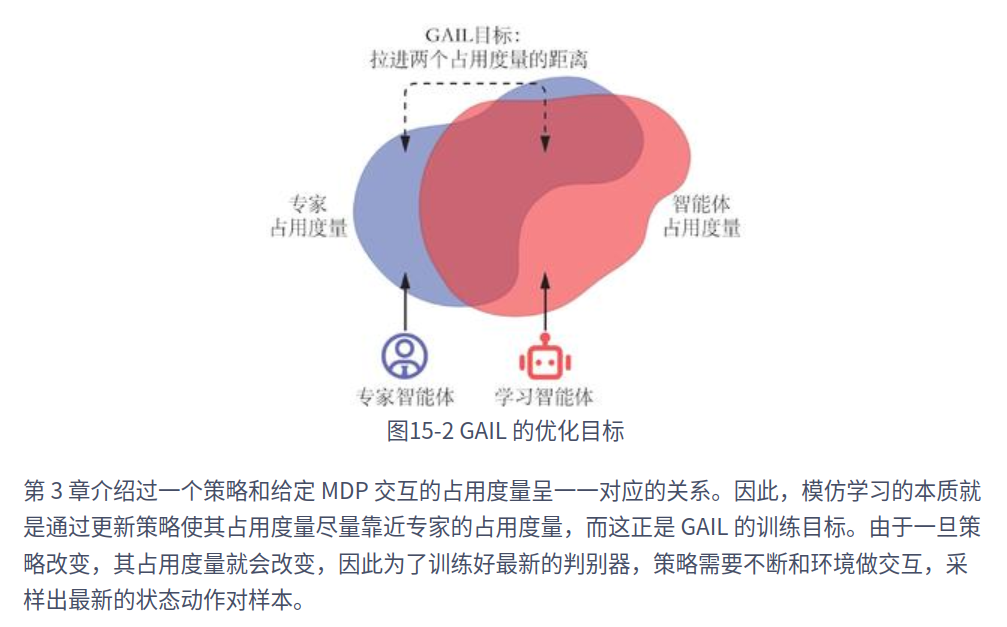

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Discriminator, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        # (batch_size,state_dim+action_dim)
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        return torch.sigmoid(self.fc2(x))
        # 输出范围[0,1]

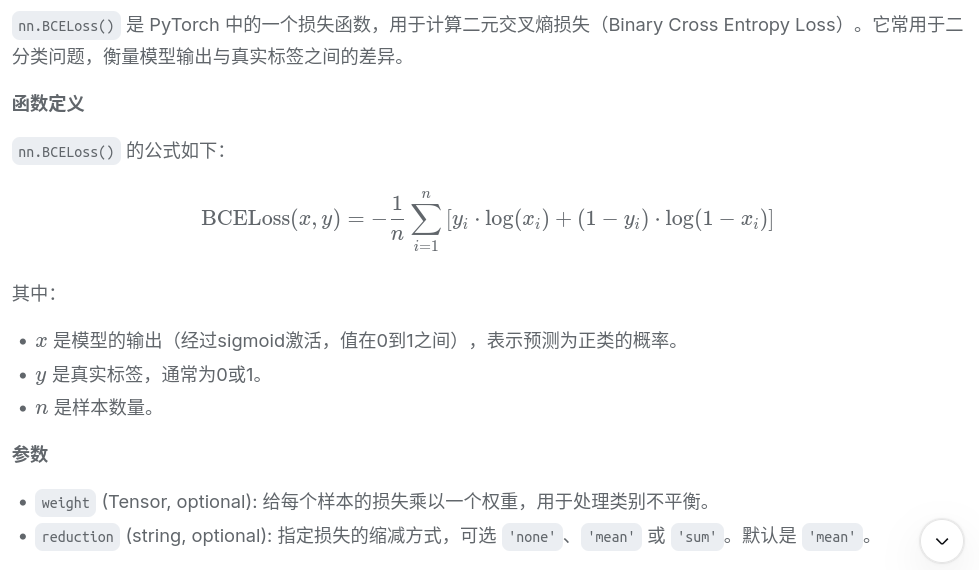

In [ ]:
class GAIL:
    def __init__(self, agent, state_dim, action_dim, hidden_dim, lr_d):
        self.discriminator = Discriminator(state_dim, hidden_dim,action_dim).to(device)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr_d)
        self.agent = agent#策略网络，输入s，输出a
        self.criterion=nn.BCELoss()

    def learn(self, expert_s, expert_a, agent_s, agent_a, next_s, dones):
        # (sample_size,state_dim),(30,state_dim)
        expert_states = torch.tensor(expert_s, dtype=torch.float).to(device)
        # (sample_size,1)
        expert_actions = torch.tensor(expert_a).to(device)
        # (sample_size,action_dim)
        expert_actions = F.one_hot(expert_actions, num_classes=2).float()
        # (sample_size,1)
        expert_prob = self.discriminator(expert_states, expert_actions)# 输出接近0更好
        # (sample_size,1)
        expert_labels = torch.zeros_like(expert_prob) # 专家数据标签为0
        # -log(1-D(s,a_e))，对sample_size个数据求平均，输出一个标量
        loss_expert = self.criterion(expert_prob, expert_labels)

        # 一个episode的数据，不知道具体长度(episode_num_step,state_dim)
        agent_states = torch.tensor(agent_s, dtype=torch.float).to(device)
        # (episode_num_step,1)
        agent_actions = torch.tensor(agent_a).to(device)
        # (episode_num_step,action_dim)
        agent_actions = F.one_hot(agent_actions, num_classes=2).float()
        # (episode_num_step,1)
        agent_prob = self.discriminator(agent_states, agent_actions)# 输出接近1更好
        # (episode_num_step,1)
        agent_labels = torch.ones_like(agent_prob) # 智能体数据标签为1
        # -log(D(s,a_p))，对episode_num_step个求均值，输出一个标量
        loss_agent = self.criterion(agent_prob, agent_labels)

        discriminator_loss = loss_expert + loss_agent
        
        self.discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        self.discriminator_optimizer.step()

        # (episode_num_step,1)
        rewards = -torch.log(agent_prob).detach().cpu().numpy()
        # 当被分辨出来时，奖励值非常低，目标是让判别器分辨不出来，agent_prob->0

        transition_dict = {
            'states': agent_s,
            'actions': agent_a,
            'rewards': rewards,
            'next_states': next_s,
            'dones': dones
        }
        
        self.agent.update(transition_dict)

In [19]:
env.reset(seed=0)
torch.manual_seed(0)
lr_d = 1e-3
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)
gail = GAIL(agent, state_dim, action_dim, hidden_dim, lr_d)
n_episode = 500
return_list = []

with tqdm(total=n_episode, desc="进度条") as pbar:
    for i in range(n_episode):
        episode_return = 0
        state = env.reset()[0]
        done = False
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, truncated ,_= env.step(action)
            # 有些环境没有done，时间到了truncated为true
            done = done or truncated
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done_list.append(done)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        # 输入是智能体的一个episode的数据和采样出来的30个专家数据
        gail.learn(expert_s, expert_a, state_list, action_list,
                   next_state_list, done_list)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)


进度条:   0%|          | 0/500 [00:00<?, ?it/s]

进度条: 100%|██████████| 500/500 [02:12<00:00,  3.79it/s, return=486.500]


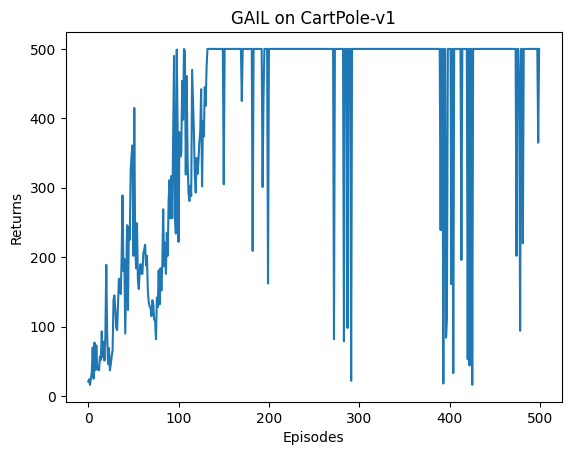

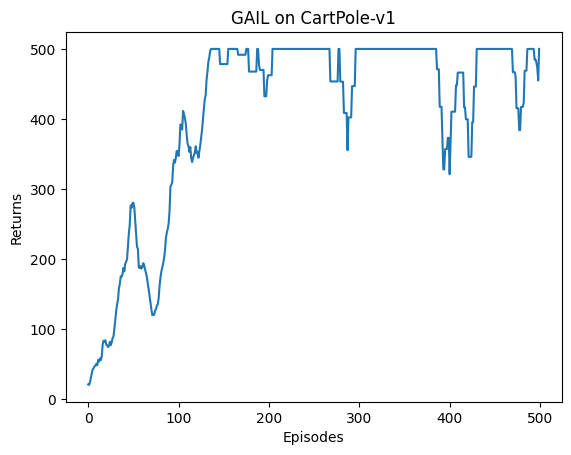

In [26]:
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('GAIL on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(iteration_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('GAIL on {}'.format(env_name))
plt.show()